<a href="https://colab.research.google.com/github/mojtabaSefidi/Fall-Detection-System/blob/master/Fall_Detection_System_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Imports and installation

In [42]:
!pip install -q tqdm

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import compute_class_weight
from itertools import groupby, chain
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
from math import sqrt
import seaborn as sn
import pandas as pd
import numpy as np
import random
import pickle
import glob
import os
sn.set()


In [44]:
window_size = 200

### Additional Functions

In [45]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_confusion_matrix(confusion_matrix, title='', cmap ='Purples'):
    df = pd.DataFrame(confusion_matrix, range(len(confusion_matrix)), range(len(confusion_matrix)))
    plt.figure(figsize=(6,3))
    if title == '' :
        plt.title('Confusion Matrix')
    else:
        plt.title('Confusion Matrix for' + ' ' + title)
    sn.set(font_scale=1) # for label size
    sn.heatmap(df, annot=True, annot_kws={"size": 12},fmt='.0f',cmap=cmap) # font size
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()


def plot_precision_recall_curve(actual_labels, prediction, title='', file_name=None):
    precision, recall, thresholds=precision_recall_curve(actual_labels, prediction)
    plt.figure(figsize=(8,6))
    fig, ax = plt.subplots()
    ax.plot(recall, precision, color='purple')

    # add axis labels to plot
    if title == '':
        plt.title(title)
    else:
        plt.title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

    # display plot
    plt.show()
    if file_name is not None:
        plt.savefig(file_name)

def plot_roc_curve(actual_labels, prediction, title='', file_name=None):
    fpr, tpr, _ = roc_curve(actual_labels, prediction)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr)
    if title == '':
        plt.title(title)
    else:
        plt.title('ROC Learning Curves')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()

    if file_name is not None:
        plt.savefig(file_name)


def plot_metrics(history):
    metrics = ['loss', 'PRC', 'Precision', 'Recall']
    plt.figure(figsize=(10,10),linewidth = 7, edgecolor="whitesmoke")

    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
        plt.ylim([0.8,1])
    else:
        plt.ylim([0,1])

    plt.legend()

def plot_auc_curve(actual_labels, prediction, model_name, title='', file_name = None):
    fpr, tpr, _ = roc_curve(actual_labels,  prediction)
    auc = roc_auc_score(actual_labels, prediction).round(4)
    plt.figure(figsize=(8,6))
    if title == '':
        plt.title(title)
    else:
        plt.title('AUC Learning Curves')
    plt.plot(fpr,tpr, label='Model: '+ model_name + ", AUC=" + str(auc), color='red')
    plt.legend(loc=4)
    plt.show()
    if file_name is not None:
        plt.savefig(file_name)

def plot_history(history):

    plt.figure(figsize=(10,5),linewidth = 7, edgecolor="whitesmoke")
    n = len(history.history['Accuracy'])

    plt.plot(np.arange(0,n)+1,history.history['Accuracy'], color='orange',marker=".")
    plt.plot(np.arange(0,n)+1,history.history['loss'],'b',marker=".")

    # offset both validation curves
    plt.plot(np.arange(0,n)+ 1,history.history['val_Accuracy'],'r')
    plt.plot(np.arange(0,n)+ 1,history.history['val_loss'],'g')

    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)

    # set vertical limit to 1
    plt.gca().set_ylim(0,1)

    plt.xlabel("Number of Epochs")
    plt.ylabel("Value")
    plt.suptitle("Learning Curve", size=16, y=0.927)
    plt.show()


## Pre-Processor

In [4]:
class DatasetProcessor():

  def get_file_name(self, path, ratio=0.8):
    allfiles = []
    allFolders = sorted(glob.glob(path + "*"))
    for files in allFolders:
      allfiles.append(sorted(glob.glob(files+"/*.txt")))
    if 'desktop.ini' in allfiles:
          allfiles.remove('desktop.ini')

    dataset = np.hstack(allfiles)
    start = dataset[0].rfind('/') + 1
    end = dataset[0][start:].find('_') + start
    dataset = [list(g) for k, g in groupby(dataset, key=lambda x: x[start:end])]
    train = []
    test = []
    for data in dataset:
      if len(data) == 1:
        if random.randint(1,100)>=81:
          test.extend(data)
        else:
          train.extend(data)

      else:
        random.shuffle(data)
        train.extend(data[:int(len(data)*ratio)])
        test.extend(data[int(len(data)*ratio):])

    return train, test

  def __read_data(self, data_path):
    data = pd.read_csv(data_path, header=None)
    data.columns = ['ADXL345_x', 'ADXL345_y', 'ADXL345_z', 'ITG3200_x', 'ITG3200_y', 'ITG3200_z', 'MMA8451Q_x',
                    'MMA8451Q_y', 'MMA8451Q_z']
    data['MMA8451Q_z'] = data['MMA8451Q_z'].map(lambda x: str(x)[:-1])
    for name in data.columns :
      data[name] = data[name].astype(float)
    return data

  def __add_label(self, data_path, merge_feature=False):

    dataset = self.__read_data(data_path)

    if not merge_feature:
      dataset['label'] = self.__get_label(data_path)
      return dataset.to_numpy()

    else:
      new_dataset = pd.DataFrame()
      new_dataset['acc_1'] = dataset.apply(
          lambda row: sqrt((row.ADXL345_x ** 2 + row.ADXL345_y ** 2 + row.ADXL345_z ** 2)), axis=1)
      new_dataset['acc_2'] = dataset.apply(
          lambda row: sqrt((row.MMA8451Q_x ** 2 + row.MMA8451Q_y ** 2 + row.MMA8451Q_z ** 2)), axis=1)
      new_dataset['geo'] = dataset.apply(
          lambda row: sqrt((row.ITG3200_x ** 2 + row.ITG3200_y ** 2 + row.ITG3200_z ** 2)), axis=1)
      new_dataset['label'] = self.__get_label(data_path)

      return np.round(new_dataset.to_numpy(), 2)

  def __get_label(self, data_path):
    label = data_path[54]
    if label =='D':
      return int(0)
    elif label =='F':
      label_path = data_path.replace('dataset', 'enhanced')
      labels = pd.read_csv(label_path, header=None)
      return labels

  def datasets_to_nparray(self, datasets_address_array, outputsize=20000000, column_dimension=10):
    result = np.zeros((outputsize, column_dimension), 'int16')
    first_index = 0
    for address in tqdm(datasets_address_array, ncols=50):
      feature = self.__add_label(address)
      result[first_index : (first_index+len(feature))] = feature
      first_index += len(feature)

    return result[result.sum(axis=1) != 0]

  def windowing2d(self, dataset, window_size=200):
    window = window_size * (dataset.shape[1]-1)
    cut = dataset.shape[0] % window_size
    feature = dataset[:-cut,0:-1]
    label = dataset[:-cut,-1]
    feature = feature.ravel().reshape(feature.size//window,window)
    label = label.reshape(label.size// window_size, window_size)
    label = label.sum(axis=1)
    label[label > 0] = 1
    feature = np.roll((np.roll(feature, -1, axis=0) - feature), 1, axis=0)
    feature[0] = 0
    return feature, label.ravel()

  def windowing3d(self, dataset, window_size=200):
    n_windows = len(dataset) // window_size
    cut = dataset.shape[0] % window_size
    feature = dataset[:-cut,0:-1]
    label = dataset[:-cut,-1]
    feature = feature.reshape(n_windows, window_size, dataset.shape[1]-1)
    label = label.reshape(n_windows, window_size, 1)
    label = label.sum(axis=1)
    label[label > 0] = 1
    feature = np.roll((np.roll(feature, -1, axis=0) - feature), 1, axis=0)
    feature[0] = 0
    return feature, label.ravel()

  def normalizer(self, scaler, X_train, X_test):
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    return X_train, X_test

  def dataset_to_tensor(self, window_size, dataset, saving_path):
    features, labels = self.windowing(self.__datasets_to_nparray(dataset), window_size)
    return features, labels

  def downsampling(self, dataset, down_sampleing_factor):
      positive = dataset[dataset['targets']==1]
      negative = dataset[dataset['targets']==0].sample(n=int(len(positive)* down_sampleing_factor))
      return pd.concat([positive, negative], ignore_index=True).sample(frac=1).reset_index(drop=True)

  def generate_class_weight(self, label):
    class_weights = compute_class_weight(class_weight = "balanced",
                                         classes = np.unique(label),
                                         y = label)
    return dict(zip(np.unique(label), class_weights))


In [ ]:
%%time

dp = DatasetProcessor()
print('1.Split Adresses...')
train, test = dp.get_file_name('/content/gdrive/MyDrive/Datasets/SisFall_dataset/')

print('2.Extract Features and Labels...')
print('------------------------Train Dataset')
train_dataset = dp.datasets_to_nparray(train)
print('------------------------Test Dataset')
test_dataset = dp.datasets_to_nparray(test)

print('3.Windowing...')
print('------------------------Train Dataset')
X_train, y_train = dp.windowing3d(train_dataset)
print('------------------------Test Dataset')
X_test, y_test = dp.windowing3d(test_dataset)

print('4.Normalizing...')
scaler = StandardScaler()
X_train, X_test = dp.normalizer(scaler, X_train, X_test)

print('5.Calculate Class Weight...')
class_weight = dp.generate_class_weight(y_train)


1.Split Adresses...
2.Extract Features and Labels...
------------------------Train Dataset


  9%|▉         | 327/3508 [00:39<24:38,  2.15it/s]

### Save/Load train & test dataset

In [7]:
save = False
if save:
  with open('/content/gdrive/MyDrive/Fall Detection System/Dataset/X_train','wb') as f:
    pickle.dump(X_train, f)

  with open('/content/gdrive/MyDrive/Fall Detection System/Dataset/y_train.pkl','wb') as f:
    pickle.dump(y_train, f)

  with open('/content/gdrive/MyDrive/Fall Detection System/Dataset/X_test.pkl','wb') as f:
    pickle.dump(X_test, f)

  with open('/content/gdrive/MyDrive/Fall Detection System/Dataset/y_test.pkl','wb') as f:
    pickle.dump(y_test, f)

else:
  with open('/content/gdrive/MyDrive/Fall Detection System/Dataset/X_train.pkl','rb') as f:
    X_train = pickle.load(f)

  with open('/content/gdrive/MyDrive/Fall Detection System/Dataset/y_train.pkl','rb') as f:
    y_train = pickle.load(f)

  with open('/content/gdrive/MyDrive/Fall Detection System/Dataset/X_test.pkl','rb') as f:
    X_test = pickle.load(f)

  with open('/content/gdrive/MyDrive/Fall Detection System/Dataset/y_test.pkl','rb') as f:
    y_test = pickle.load(f)
    dp = DatasetProcessor()
    class_weight = dp.generate_class_weight(y_train)


In [8]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (61036, 200, 9)
y_train shape: (61036,)
X_test shape: (16375, 200, 9)
y_test shape: (16375,)


## Train & Evaluate

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='TP'),
      keras.metrics.FalsePositives(name='FP'),
      keras.metrics.TrueNegatives(name='TN'),
      keras.metrics.FalseNegatives(name='FN'),
      keras.metrics.BinaryAccuracy(name='Accuracy'),
      keras.metrics.Precision(name='Precision'),
      keras.metrics.Recall(name='Recall'),
      keras.metrics.AUC(name='AUC'),
      keras.metrics.AUC(name='PRC', curve='PR')
]

early_stopping = keras.callbacks.EarlyStopping(
    monitor='Precision',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# checkpoint_path = "/content/gdrive/MyDrive/Model Checkpoints/TrendDetection.ckpt"
# # save_freq = 'epoch'

# cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(
#    checkpoint_path, verbose=1, save_weights_only=True,
#    # Save weights, every epoch.
#    save_freq = 10*3030)

In [55]:
class Traditional_Models():

  def __init__(self,
               models,
               model_parameters,
               predictions={},
               results={}):
    self.models = models
    self.model_parameters = model_parameters
    self.predictions = predictions
    self.results = results

  def __validation(self, X_train, y_train, validation_size=0.35):
    _, X_validation, _, y_validation = train_test_split(X_train, y_train, test_size=validation_size, stratify=y_train)
    return X_validation, y_validation

  def __flatten(self, feature_3d):
    return feature_3d.reshape(feature_3d.shape[0], feature_3d.shape[1]*feature_3d.shape[-1])

  def __feature_selector(self, X_train, y_train, X_test, class_weight, d=64):
    feature_selector = DecisionTreeClassifier(class_weight=class_weight).fit(X_train, y_train)
    important_features = np.argpartition(feature_selector.feature_importances_, -d)[-d:]
    return X_train[:,important_features], X_test[:,important_features]

  def __parameter_tuning(self, model, parameters, X_validation, y_validation, scoring='f1_macro'):
    optimizer = GridSearchCV(estimator=model, param_grid=parameters, scoring=scoring)
    optimizer.fit(X_validation, y_validation)
    return model.set_params(**optimizer.best_params_)

  def __train_model(self, model, X_train, y_train):
    return model.fit(X_train, y_train)

  def __evaluate(self, model, X_test, y_test, title=''):
    prediction = model.predict(X_test)
    self.results[title] = classification_report(y_test, prediction, output_dict=True)
    plot_confusion_matrix(confusion_matrix(y_test, prediction), title=title)
    return prediction

  def pipeline(self,
               X_train,
               y_train,
               X_test,
               y_test,
               class_weight,
               validation_size=35,
               number_features=64,
               tuning_metric='f1_macro'):
    print('1) Reducing dimension of feature matrices...')
    X_train_flattened, X_test_flattened = self.__flatten(X_train), self.__flatten(X_test)
    print('2) Feature selection...')
    X_train_flattened, X_test_flattened = self.__feature_selector(X_train_flattened, y_train, X_test_flattened, class_weight=class_weight, d=number_features)
    print('3) Generating validation matrices for hyper-parameter tuning...')
    X_validation, y_validation = self.__validation(X_train_flattened, y_train, validation_size=validation_size)
    print('4) Train & Evaluation...')
    for model_name, model in self.models.items():
      print()
      print(f'    ----------------- Working on {model_name} -----------------')
      print()
      if model_name in self.model_parameters:
        model = self.__parameter_tuning(model, self.model_parameters[model_name], X_validation, y_validation, scoring=tuning_metric)
      mdoel =  self.__train_model(model, X_train_flattened, y_train)
      self.predictions[model_name] = self.__evaluate(model, X_test_flattened, y_test, title=model_name)
    return self.predictions, self.results

In [56]:
model_parameters = {'KNN':{'n_neighbors':[2,4,8,16], 'metric':['euclidean','cosine']},
                    'Random Forest':{'criterion':['gini', 'entropy', 'log_loss']}
                    }


tradional_models = Traditional_Models(models = {'Logestic Regression':LogisticRegression(class_weight=class_weight),
                                                'Random Forest':RandomForestClassifier(class_weight=class_weight),
                                                'KNN':KNeighborsClassifier()},
                                      model_parameters = model_parameters)

1) Reducing dimension of feature matrices...
2) Feature selection...
3) Generating validation matrices for hyper-parameter tuning...
4) Train & Evaluation...

    ----------------- Working on Logestic Regression -----------------



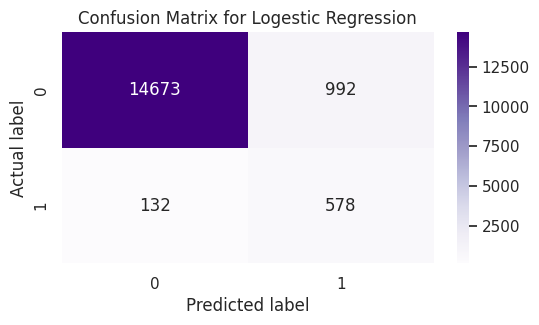


    ----------------- Working on Random Forest -----------------



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


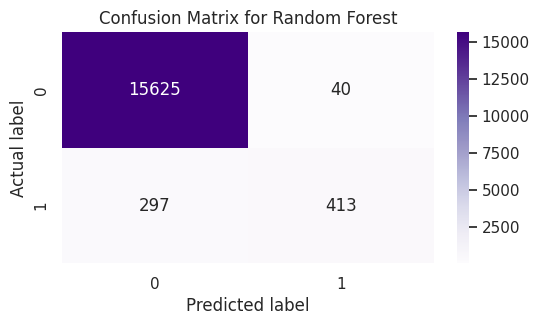


    ----------------- Working on KNN -----------------



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


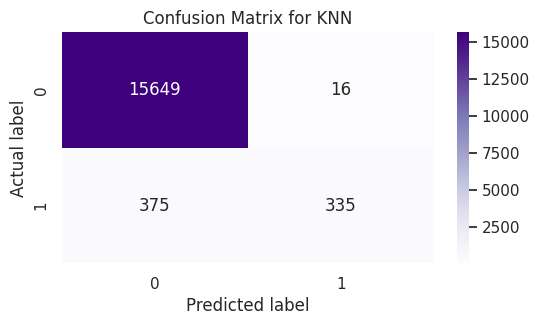

In [57]:
predictions, results = tradional_models.pipeline(X_train,
                                                 y_train,
                                                 X_test,
                                                 y_test,
                                                 class_weight)

In [ ]:
class Train_Evaluate_Deep():

  def __init__(self,
               predictions={},
               results={}):

      self.predictions = predictions
      self.results = results

  def build_cnn(self, input_size, units=128, drop_rate=0.25, filter=32, kernel_size=(1*9), output_size=1):
    input = keras.layers.Input((input_size))
    x = keras.layers.Conv1D(filters=filter, kernel_size=kernel_size, padding='same', activation='relu', name="conv1")(input)
    x = keras.layers.Conv1D(filters=filter*2, kernel_size=kernel_size, padding='same', activation='relu', name="conv2")(x)
    x = keras.layers.Conv1D(filters=filter*4, kernel_size=kernel_size, padding='same', activation='relu', name="conv3")(x)
    x = tf.keras.layers.Flatten()(x)
    classifier = keras.layers.Dense(units*4, activation='relu')(x)
    classifier = keras.layers.Dropout(drop_rate)(classifier)
    classifier = keras.layers.Dense(units, activation='relu')(classifier)
    classifier = keras.layers.Dropout(drop_rate)(classifier)
    classifier = keras.layers.Dense(units//2, activation='relu')(classifier)
    classifier = keras.layers.Dropout(drop_rate)(classifier)
    output = keras.layers.Dense(output_size, activation='sigmoid')(classifier)
    model = keras.Model(inputs=input, outputs=output)
    return model

  def build_lstm(self, input_size, units=128, drop_rate=0.25, lstm_units=16, output_size=1):
    input = keras.layers.Input((input_size))
    x = keras.layers.LSTM(units=lstm_units, input_shape=input_size, return_sequences=True, name="lstm1")(input)
    x = keras.layers.LSTM(units=lstm_units*4, input_shape=input_size, return_sequences=True, name="lstm2")(x)
    x = tf.keras.layers.Flatten()(x)
    classifier = keras.layers.Dense(units*4, activation='relu')(x)
    classifier = keras.layers.Dropout(drop_rate)(classifier)
    classifier = keras.layers.Dense(units, activation='relu')(classifier)
    classifier = keras.layers.Dropout(drop_rate)(classifier)
    classifier = keras.layers.Dense(units//2, activation='relu')(classifier)
    classifier = keras.layers.Dropout(drop_rate)(classifier)
    output = keras.layers.Dense(output_size, activation='sigmoid')(classifier)
    model = keras.Model(inputs=input, outputs=output)
    return model

  def build_mlp(self, input_size, hidden_layer_size=128, output_size=1, drop_rate=0.25):
    input = keras.layers.Input((input_size))
    x = keras.layers.Dense(hidden_layer_size//4, activation='relu')(input)
    x = keras.layers.Dense(hidden_layer_size//2, activation='relu')(x)
    x = keras.layers.Dense(hidden_layer_size, activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    classifier = keras.layers.Dense(hidden_layer_size*4, activation='relu')(x)
    classifier = keras.layers.Dropout(drop_rate)(classifier)
    classifier = keras.layers.Dense(hidden_layer_size, activation='relu')(classifier)
    classifier = keras.layers.Dropout(drop_rate)(classifier)
    classifier = keras.layers.Dense(hidden_layer_size//2, activation='relu')(classifier)
    classifier = keras.layers.Dropout(drop_rate)(classifier)
    output = keras.layers.Dense(output_size, activation='sigmoid')(classifier)
    model = keras.Model(inputs=input, outputs=output)
    return model


  def train_deep_model(self, model, X_train, y_train, class_weight, epochs=100, batch_size=256, learning_rate=0.001, validation_split=0.2):

    print('----------------------------------')
    print(model.summary())
    print('----------------------------------')

    model.compile(optimizer = tf.optimizers.SGD(learning_rate=learning_rate),
                  loss = keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)

    history = model.fit(X_train,
                        y_train,
                        batch_size = batch_size,
                        epochs = epochs,
                        shuffle = True,
                        class_weight = class_weight,
                        validation_split=validation_split,
                        callbacks = [early_stopping],
                        verbose = 1)
    return history

  def evaluate(self, model, X_test, y_test, batch_size=256, threshold=0.5, title='', model_name='', plot=True):
    prediction = model.predict(X_test, batch_size=batch_size)
    prediction = np.where(prediction >= threshold, 1, 0)
    report = classification_report(y_test, prediction, output_dict=True)
    plot_confusion_matrix(confusion_matrix(y_test, prediction), title=title)
    if plot:
      print('1) Plot ROC Curve...')
      plot_roc_curve(y_test, prediction, title='ROC Curve Of Model'+title, file_name=None)
      print('2) Plot AUC Curve...')
      plot_auc_curve(y_test, prediction, model_name=model_name, title='AUC Curve Of Model'+title, file_name = None)
      print('3) Plot Percision_Recall Curve......')
      plot_precision_recall_curve(y_test, prediction, title='Percision_Recall Curve Of Model'+title, file_name=None)
    return prediction

  def plot_learning_curves(self, history):
    print('1) Plot learning process based on different metrics...')
    plot_metrics(history)
    print('2) Plot learning curve...')
    return plot_history(history)

In [ ]:
1.
cnn_model = train_evaluate.build_cnn(input_size=X_train.shape[1:])

cnn_history = train_evaluate.train_deep_model(cnn_model, X_train, y_train, class_weight, epochs=2)

In [ ]:
LSTM_model = train_evaluate.build_lstm(input_size=X_train.shape[1:])
LSTM_history = train_evaluate.train_deep_model(LSTM_model, X_train, y_train, class_weight, epochs=2)

----------------------------------
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 200, 9)]          0         
                                                                 
 lstm1 (LSTM)                (None, 200, 16)           1664      
                                                                 
 lstm2 (LSTM)                (None, 200, 64)           20736     
                                                                 
 flatten_7 (Flatten)         (None, 12800)             0         
                                                                 
 dense_28 (Dense)            (None, 128)               1638528   
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_29 (Dense)      

In [ ]:
mlp_model = train_evaluate.build_mlp(input_size=X_train.shape[1:], hidden_layer_size=128, output_size=1)
mlp_history = train_evaluate.train_deep_model(mlp_model, X_train, y_train, class_weight, epochs=2)


----------------------------------
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 200, 9)]          0         
                                                                 
 dense_32 (Dense)            (None, 200, 128)          1280      
                                                                 
 dense_33 (Dense)            (None, 200, 64)           8256      
                                                                 
 dense_34 (Dense)            (None, 200, 32)           2080      
                                                                 
 dense_35 (Dense)            (None, 200, 8)            264       
                                                                 
 flatten_8 (Flatten)         (None, 1600)              0         
                                                                 
 dense_37 (Dense)      

Prediction based on Ensemble Concept

Models' Summary

In [ ]:
conclusion = pd.DataFrame([['Neural Network',precision_1,recall_1,f1Score_1],
              ['Logistic Regression',0.53,0.17,0.26],
              ['SVM',0.38,0.01,0.03],
              ['KNN',0.94,0.56,0.70],
              ['Neural Network after Balancing',precision_2,recall_2,f1Score_2],
              ['Logistic Regression after Balancing',0.08,0.93,0.15],
              ['SVM after Balancing',0.06,0.97,0.11],
              ['KNN after Balancing',0.73,0.73,0.73],
              ['Ensemble concept after Balancing',0.65,0.81,0.72]],
              columns=["Model","Precision","Recall","F1score"])
# conclusion = conclusion.set_index('Algorithm')
conclusion.style.background_gradient(cmap="YlGn")


,Precision,Recall,F1score
Algorithm,,,
Neural Network,0.990000,0.340000,0.510000
Logistic Regression,0.530000,0.170000,0.260000
SVM,0.380000,0.010000,0.030000
KNN,0.940000,0.560000,0.700000
Neural Network after Balancing,0.880000,0.580000,0.700000
Logistic Regression after Balancing,0.080000,0.930000,0.150000
SVM after Balancing,0.060000,0.970000,0.110000
KNN after Balancing,0.730000,0.730000,0.730000
Ensemble concept after Balancing,0.650000,0.810000,0.720000


As you see After Blancing the dataset Ensemble concept and KNN model do the best !